# Generate measurements from ground truth
     Now we have the ground truht lifetime and intensity image generated from EMNIST, we use them to generate a 3D measurement dataset, or as the NetFLICS papers call, Time-Point-Spread-Function (TPSF) map.
     There are two steps as follow:
     - For each pixel in lifetime and intensity image, we can get the intensity and lifetime value and use them to generate an intensity decay curve.
     - Having the Intensity decay curve for each pixel, convolute them using the Instrumental-Response-Function to get raw measurements

In [ ]:
# Parameters
sample_size = 8000
image_size = 128
lifetime_size = 256

### Read in the data

In [16]:
import h5py
import numpy as np

with h5py.File('Data/ground_truth.h5','r')as f:
    intensity_GT = np.array(f['intensity_ground_truth'])
    lifetime_GT = np.array(f['lifetime_ground_truth'])
    

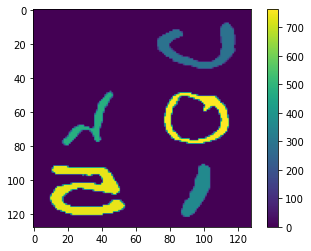

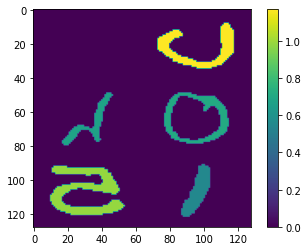

In [26]:
from utilities import draw
draw(intensity_GT[937,:,:])
draw(lifetime_GT[937,:,:])

### A function that takes in lifetime and intensity value of a pixel, return a hist of 256 entries, each has time width of 32.6ps
    A Time-Point-Spread-Function is a binned itensity measurements over time
    256 bins of 32.6ps each is 83456 ps, (8.3456ns), compare to 0.3-1.2 ns 
    Excitation starts at 20th bin

In [202]:
import diplib as dip
IRF = np.array(dip.ImageRead('Data\Prompt\prompt 870nm 510nm.ics'))

def gen_raw_measurement(intensity_value, lifetime_value):
    raw_measurement = np.zeros(lifetime_size)
    raw_measurement_time = np.linspace(0.,8.3456,num=lifetime_size,endpoint=False)
    # Generate Curve for each line according to e^-t/tau, intensity will be reflected on the scaling later
    for i in range(lifetime_size):
        raw_measurement[i] = np.exp(-raw_measurement_time[i]/lifetime_value)
    # Convolve with the IRF
    raw_measurement = np.convolve(raw_measurement,np.squeeze(IRF))[:lifetime_size]
    # Scale so sum of all photon count to intensity
    raw_measurement = np.round(raw_measurement * intensity_value / sum(raw_measurement))
    return raw_measurement.astype(np.uint8)

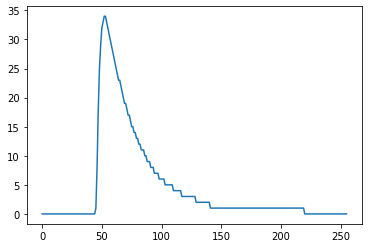

In [203]:
import matplotlib.pyplot as plt
plt.plot(gen_TPSF(1200,0.8))
plt.show()

In [204]:
sum(gen_TPSF(400,0.8))

373

In [205]:
intensity_GT.shape

(8000, 128, 128)

### Simulate raw measurements
Run the gen_raw_measurements function for all pixels.

In [206]:
import scipy
import tqdm

In [207]:
# For each image i
for i in tqdm.tqdm(range(sample_size)):# Doing 8000 (all) images
    measurements = np.zeros([image_size,image_size,lifetime_size]).astype(int)
    # for each row x
    for x in range(image_size):
        # for each pixel in column y
        for y in range(image_size):
            if intensity_GT[i][x][y] != 0 and lifetime_GT[i][x][y] != 0:
                measurements[x][y] = gen_raw_measurement(intensity_GT[i][x][y],lifetime_GT[i][x][y])
            else:
                # if intensity is zero just return all zero
                measurements[x][y] = 0
    scipy.io.savemat(('Data\Raw_Measurements\sample_'+str(i)+'.mat'), {'measurements': measurements})

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [2:48:54<00:00,  1.27s/it]
